In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['TRANSFORMERS_CACHE'] = "/media/data/flowers/OpenELM/models"
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np
import json 
from openelm.environments.p3 import skill_list,P3_probsol_chat_med_seed
import pickle
from tqdm import tqdm
from langchain.schema import HumanMessage
from transformers import pipeline

# model_id= "Salesforce/codet5p-110m-embedding"
# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto")
model = None
tokenizer =None

def getallitems(maps):
    """
    Returns all the phenotypes that are in the Map."""
    genomes = maps["genomes"]
    valid_phenotype=[]
    for gen in np.ndindex(genomes.shape):
        value_gen = type(genomes[gen])
        if value_gen!=float and value_gen!=int:
            valid_phenotype.append(genomes[gen])

    return valid_phenotype



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /media/data/flowers/conda/envs/codegpt/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


In [3]:
puzz="from typing import*\ndef f(s: str) -> bool:\n    \"\"\"Check if the given string is a valid URL.\"\"\"\n    return s.startswith('http://') or s.startswith('https://')\ndef g():\n    return 'https://www.example.com'\nassert f(g())\n"
puzz_2="from typing import*\ndef f(s: str) -> bool:\n    \"\"\"Check if the given string is a valid email address.\"\"\"\n    return '@' in s and '.' in s and s.index('@') < s.index('.')\ndef g():\n    return 'john.doe@example.com'\nassert f(g())\n"
print(puzz)
print()
print(puzz_2)

from typing import*
def f(s: str) -> bool:
    """Check if the given string is a valid URL."""
    return s.startswith('http://') or s.startswith('https://')
def g():
    return 'https://www.example.com'
assert f(g())


from typing import*
def f(s: str) -> bool:
    """Check if the given string is a valid email address."""
    return '@' in s and '.' in s and s.index('@') < s.index('.')
def g():
    return 'john.doe@example.com'
assert f(g())



In [64]:
[func.name for func in ast.walk(tree) if isinstance(func, ast.FunctionDef)]

['f', 'g']

In [63]:
visitor.calls

['ord', 'ord', 'ord', 'ord', 'range', 'abs', 'f', 'f']

In [2]:
# # seed 1
# # prev link
# imgep_smart = "/media/data/flowers/OpenELM/logs/elm/23-08-26_15:17/step_399/save_all.json"# 20 #"/media/data/flowers/OpenELM/logs/elm/23-08-25_11:24/step_299/save_all.json" # 15$

# # imgep random
# # expe 1
# imgep_random ="/media/data/flowers/OpenELM/logs/elm/23-08-26_17:12/step_399/save_all.json"# 20$ "/media/data/flowers/OpenELM/logs/elm/23-08-25_19:57/step_299/save_all.json" # 15$
# # ELM-NLP
# elm_NLP ="/media/data/flowers/OpenELM/logs/elm/23-08-26_18:51/step_399/save_all.json"#"/media/data/flowers/OpenELM/logs/elm/23-08-26_01:02/step_299/save_all.json" # 10.50$
# # ELM-base
# elm_base="/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399" # start at 65.48$
# # Random gen 
# rd_gen = "/media/data/flowers/OpenELM/logs/elm/23-08-26_11:55/step_399" # 10.24$ for 400 start at 41.08 to 51,32
# rd_gen+= "/save_all.json"

In [2]:
rd_gen="/media/data/flowers/OpenELM/run_saved/random_gen/step_499_1/"
elm="/media/data/flowers/OpenELM/run_saved/elm/step_499_1/"#"/media/data/flowers/OpenELM/run_saved/elm/step_499_1/"#

path_centroids= "/media/data/flowers/OpenELM/run_saved/elm/step_399_1/centroids.npy"
elm_NLP="/media/data/flowers/OpenELM/run_saved/elm_nlp/step_499_1/"#"/media/data/flowers/OpenELM/run_saved/elm_nlp/step_399_1/"
imgep_smart="/media/data/flowers/OpenELM/run_saved/imgep_smart/step_499_1/"
imgep_random="/media/data/flowers/OpenELM/run_saved/imgep_random/step_499_1/"
full_list_path_seed1=[rd_gen,elm,elm_NLP,imgep_random,imgep_smart]
list_legend = ["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]

In [4]:
"IdentifyZeroTrips:0"
path="/media/data/flowers/OpenELM/puzzles.json"
with open(path,"r") as f:
    list_puz=json.load(f)

In [10]:
for idx, puz in enumerate(list_puz):
    if "Example" in puz["sol_docstring"]:
        print(idx)
        print(puz["name"])
        print("\n")

        print(puz["sat"])
        print("\n")

        print(puz["sol_docstring"])
        print("\n")
        print(puz["sol_bodies"][0])
        print("========\n")

188
ParseMusic:0


def sat(beats: List[int], score="o o o| o| .| .| .| o| o| o o o| .|"):
    return " ".join({1: '.|', 2: 'o|', 4: 'o'}[b] for b in beats) == score


    """
    Parse a string of notes to beats, 'o'=4, 'o|'=2, '.|'=1

    Example input:
    'o o .| o|'

    Example output:
    [4, 4, 1, 2]
    """


    mapping = {'.|': 1, 'o|': 2, 'o': 4}
    return [mapping[note] for note in score.split()]

189
ParseMusic:1


def sat(beats: List[int], score=".| o .| o| o| o| o| .| o o"):
    return " ".join({1: '.|', 2: 'o|', 4: 'o'}[b] for b in beats) == score


    """
    Parse a string of notes to beats, 'o'=4, 'o|'=2, '.|'=1

    Example input:
    'o o .| o|'

    Example output:
    [4, 4, 1, 2]
    """


    mapping = {'.|': 1, 'o|': 2, 'o': 4}
    return [mapping[note] for note in score.split()]

190
ParseMusic:2


def sat(beats: List[int], score="o| .| .| .| .| o| o .| o| o| o"):
    return " ".join({1: '.|', 2: 'o|', 4: 'o'}[b] for b in beats) == score


    """
    Parse

In [ ]:
    """Find a rotation of string s that is a substring of t

    Input Example:
    s="test", t="I love lattes"

    Output Example:
    "ttes"
    """
    """Return the biggest even number between a and b inclusive, or -1 if there is no such number

    Example input:
    a=20, b=99

    Example output:
    98
    """

## no docstring

In [69]:
path_maps_wo_doc="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_smart/23-09-14_12:37/step_65/maps.pkl"
count=0
with open(path_maps_wo_doc, "rb") as f:
    maps = pickle.load(f)
allitems=getallitems(maps)
for it in allitems:
    if it.idx_generation !=-1 and it.fitness>0.:
        count+=1
        # print("===")
        # print(it.program_str)
print(count)

255


## docstring without ex

In [77]:
count=0

path_maps_doc_wo_ex="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_smart/23-09-14_13:51/step_20/maps.pkl"
with open(path_maps_doc_wo_ex, "rb") as f:
    maps = pickle.load(f)
allitems=getallitems(maps)
for it in allitems:
    if it.idx_generation>=0 and it.idx_generation<=70:
        
        if 'example' in it.program_str or 'Example' in it.program_str:
            print("===")
            print(it.program_str)
            count+=1
print(count)

===
from typing import*
def f(s: str, k=3) -> bool:
    """Find a substring of length k that appears the most number of times in the string."""
    counts = {}
    for i in range(len(s) - k + 1):
        substring = s[i:i+k]
        if substring in counts:
            counts[substring] += 1
        else:
            counts[substring] = 1
    max_count = max(counts.values())
    return sum(count == max_count for count in counts.values()) == 1

def g(k=3):
    return 'abcaabcbabccabcaabcb'  # Example string

assert f(g())

1


In [78]:
print(count)

1


In [34]:
count=0
path_maps_wo_doc="/media/data/flowers/OpenELM/logs/elm/23-09-13_19:06/step_170/"

path_maps_doc_wo_ex="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_smart/23-09-14_10:33/step_90/"
full_path_seed_test=full_list_path_seed1+[path_maps_wo_doc,path_maps_doc_wo_ex]

all_items_gen_aaaaaaa=[[] for _ in range(len(full_list_path_seed1))]

all_items_gen=[[] for _ in range(len(full_list_path_seed1))]
count_ex=[0 for _ in range(len(full_list_path_seed1))]
for path in full_list_path_seed1:
    path_maps = path + "maps.pkl"
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    list_w=["example","Example"]#,"solution"]
    for puzz in tqdm(items_gen):
        f= puzz.program_str.split("def g")[0]
        for w in list_w:
            if w in f:
                all_items_gen[count].append(puzz.program_str)
                count_ex[count]+=1
                all_items_gen_aaaaaaa[count].append(puzz.idx_generation)
                continue
    print(f"\n{list_legend[count] } : ",count_ex[count])
            
    count+=1


100%|██████████| 1451/1451 [00:00<00:00, 436173.95it/s]



random-gen :  27


100%|██████████| 3073/3073 [00:00<00:00, 410206.43it/s]



ELM :  216


100%|██████████| 2082/2082 [00:00<00:00, 413159.58it/s]



ELM-NLP :  188


100%|██████████| 2389/2389 [00:00<00:00, 333251.04it/s]



IMGEP random :  1153


100%|██████████| 2250/2250 [00:00<00:00, 322297.19it/s]


IMGEP smart :  1132


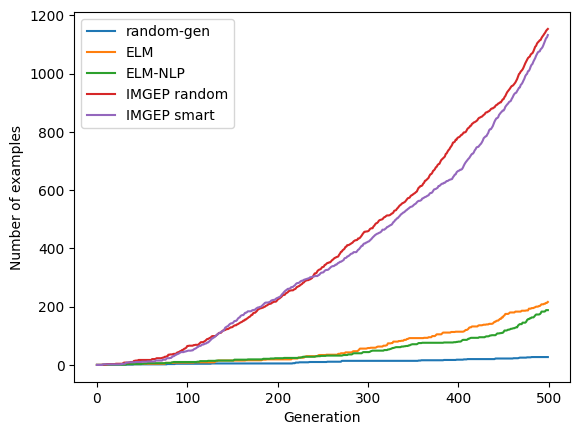

In [35]:
idx_count=[[] for i in range(len(full_list_path_seed1))]
for idx,path in enumerate(list_legend):
    for i in range(500):
        idx_count[idx].append(all_items_gen_aaaaaaa[idx].count(i))
    plt.plot(np.cumsum(idx_count[idx]),label=path)
    # plt.hist((all_items_gen_aaaaaaa[idx]))
    # plt.show()
plt.xlabel("Generation")
plt.ylabel("Number of examples")
plt.legend()
# plt.title("snowball effect of unwanted effects")
plt.savefig("/media/data/flowers/OpenELM/fig/snowball.pdf")
plt.show()



In [53]:
count=0
path_maps_wo_doc="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_smart/23-09-14_12:37/step_30/"

# path_maps_doc_wo_ex="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_smart/23-09-14_10:33/step_100/"
full_path_seed_test=full_list_path_seed1+[path_maps_wo_doc]
list_legend_test=list_legend+["without docstring"]
all_items_gen_aaaaaaa=[[] for _ in range(len(full_path_seed_test))]

all_items_gen=[[] for _ in range(len(full_path_seed_test))]
count_ex=[0 for _ in range(len(full_path_seed_test))]
for path in full_path_seed_test:
    path_maps = path + "maps.pkl"
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    list_w=["example","Example"]#,"solution"]
    for puzz in tqdm(items_gen):
        f= puzz.program_str.split("def g")[0]
        for w in list_w:
            if w in f:
                all_items_gen[count].append(puzz.program_str)
                count_ex[count]+=1
                all_items_gen_aaaaaaa[count].append(puzz.idx_generation)
                continue
    print(f"\n{list_legend_test[count] } : ",count_ex[count])
            
    count+=1


100%|██████████| 1451/1451 [00:00<00:00, 456388.08it/s]



random-gen :  27


100%|██████████| 3073/3073 [00:00<00:00, 405866.30it/s]



ELM :  216


100%|██████████| 2082/2082 [00:00<00:00, 387475.75it/s]



ELM-NLP :  188


100%|██████████| 2389/2389 [00:00<00:00, 325373.17it/s]



IMGEP random :  1153


100%|██████████| 2250/2250 [00:00<00:00, 303115.05it/s]



IMGEP smart :  1132


100%|██████████| 110/110 [00:00<00:00, 318408.17it/s]


without docstring :  0


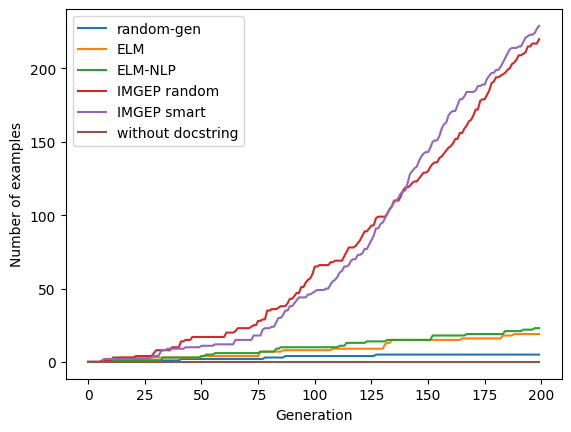

In [54]:
idx_count=[[] for i in range(len(full_path_seed_test))]
for idx,path in enumerate(list_legend_test):
    for i in range(200):
        idx_count[idx].append(all_items_gen_aaaaaaa[idx].count(i))
    plt.plot(np.cumsum(idx_count[idx]),label=path)
    # plt.hist((all_items_gen_aaaaaaa[idx]))
    # plt.show()
plt.xlabel("Generation")
plt.ylabel("Number of examples")
plt.legend()
# plt.title("snowball effect of unwanted effects")
# plt.savefig("/media/data/flowers/OpenELM/fig/snowball.pdf")
plt.show()



In [42]:
idx_count[idx]

IndexError: list index out of range

In [9]:
# 67=308
price_b0=8 # random
price_b1=8 # ELM
price_b2=10.5 # ELM + NLP space
price_b3= 16 # dumb IMGEP
price_b4 = 16 # smart IMGEP
n_expe=4
ratio=400/300
(price_b0+price_b1+price_b2+price_b3+price_b4)*n_expe*ratio

312.0

In [3]:
elm_nlp
# imgep_random ="/media/data/flowers/OpenELM/logs/elm/23-08-26_17:12/step_399/save_all.json"# 20$ "/media/data/flowers/OpenELM/logs/elm/23-08-25_19:57/step_299/save_all.json" # 15$
# # ELM-NLP
# elm_NLP ="/media/data/flowers/OpenELM/logs/elm/23-08-26_18:51/step_399/save_all.json"# 20$"/media/data/flowers/OpenELM/logs/elm/23-08-26_01:02/step_299/save_all.json" # 10.50$
# # ELM-base
# elm_base="" # 9$
# # Random gen 
# rd_gen = "/media/data/flowers/OpenELM/logs/elm/23-08-26_11:55/step_399/save_all.json" # 10.24$ for 400 start at 41.08 to 51,32

# path_centroids= "/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399/centroids.npy"
# elm="/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399/"

# finetuned performance

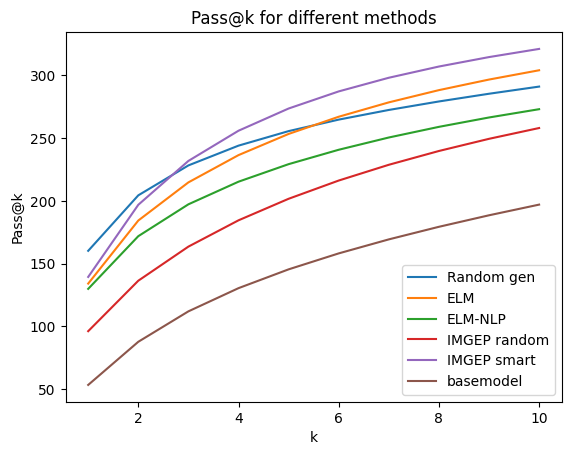

In [15]:
based_model =[53.4, 87.755,111.99166,130.4666,145.44,158.1523,169.308,179.33,188.5,197.0]

elm_nlp = [
    129.9,
    171.86666666666667,
    197.24166666666665,
    215.25238095238097,
    229.22222222222223,
    240.69047619047618,
    250.45,
    258.93333333333334,
    266.4,
    273.0
]

imgep_random_sol = [
    96.19999999999999,
    136.39999999999998,
    163.55,
    184.4952380952381,
    201.64682539682542,
    216.17142857142858,
    228.725,
    239.7111111111111,
    249.39999999999998,
    258.0
]

random_gen = [
    160.2,
    204.39999999999998,
    228.22500000000002,
    243.9714285714286,
    255.53968253968256,
    264.7,
    272.39166666666665,
    279.15555555555557,
    285.3,
    291.0
]

imgep_smart = [
    139.4,
    196.86666666666665,
    231.8,
    255.84761904761905,
    273.5357142857143,
    287.1619047619048,
    298.0416666666667,
    306.97777777777776,
    314.5,
    321.0
]

elm = [
    134.1,
    184.33333333333331,
    214.70833333333334,
    236.42380952380952,
    253.28571428571428,
    266.98571428571427,
    278.4333333333333,
    288.1777777777778,
    296.6,
    304.0
]
plt.plot(range(1,11),random_gen,label="Random gen")
plt.plot(range(1,11),elm,label="ELM") 
plt.plot(range(1,11),elm_nlp,label="ELM-NLP")
plt.plot(range(1,11),imgep_random_sol,label="IMGEP random")
plt.plot(range(1,11),imgep_smart,label="IMGEP smart")
plt.plot(range(1,11),based_model,label="basemodel")

plt.legend()
plt.xlabel("k")
plt.ylabel("Pass@k")
plt.title("Pass@k for different methods")
plt.savefig("/media/data/flowers/OpenELM/fig/fine_tune_seed0.pdf")

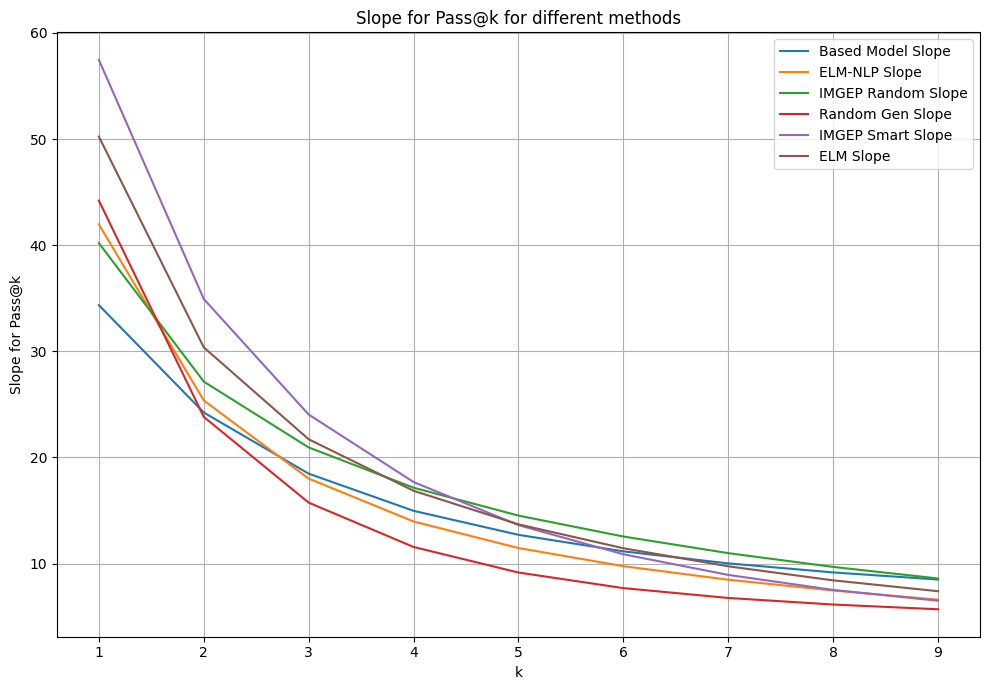

In [17]:
import matplotlib.pyplot as plt

def compute_slopes(data):
    slopes = []
    for i in range(len(data) - 1):
        slope = (data[i+1] - data[i])
        slopes.append(slope)
    return slopes

# Compute the slopes
based_model_slope = compute_slopes(based_model)
elm_nlp_slope = compute_slopes(elm_nlp)
imgep_random_sol_slope = compute_slopes(imgep_random_sol)
random_gen_slope = compute_slopes(random_gen)
imgep_smart_slope = compute_slopes(imgep_smart)
elm_slope = compute_slopes(elm)

# Plotting the slopes
plt.figure(figsize=(10, 7))

# Using range(1, 10) since we're plotting slopes which have one less value than the original series
plt.plot(range(1,10), based_model_slope, label="Based Model Slope")
plt.plot(range(1,10), elm_nlp_slope, label="ELM-NLP Slope")
plt.plot(range(1,10), imgep_random_sol_slope, label="IMGEP Random Slope")
plt.plot(range(1,10), random_gen_slope, label="Random Gen Slope")
plt.plot(range(1,10), imgep_smart_slope, label="IMGEP Smart Slope")
plt.plot(range(1,10), elm_slope, label="ELM Slope")

plt.legend()
plt.xlabel("k")
plt.ylabel("Slope for Pass@k")
plt.title("Slope for Pass@k for different methods")
plt.grid(True)
plt.tight_layout()

# Saving the plot as a PDF
plt.savefig("/media/data/flowers/OpenELM/fig/slopes_fine_tune_seed0.pdf")

# Displaying the plot
plt.show()


# niched filled analysis

## utils

In [3]:


# init maps
def return_cells_filled_per_gen_map_elite(path_save_all,max_gen=-1,include_trainset=False,include_full_trainset=False):
    #_init_discretization():
    n_skills=10
    behavior_space= np.repeat([[0, 1]], n_skills, axis=0).T

    bins = np.linspace(*behavior_space,  3)[1:-1].T  # type: ignore
    # bins
    def to_mapindex(b, bins=bins) :
        """Converts a phenotype (position in behaviour space) to a map index."""
        return (
            None
            if b is None
            else tuple(np.digitize(x, bins) for x, bins in zip(b, bins))
        )
        

    path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"

    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    items_trainset = [item for item in allitems if item.idx_generation==-1]
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    if "/elm/" in path_save_all and "run_saved" in path_save_all:
        elm_phenotype = path_save_all.split("maps.pkl")[0]+"_phenotype.npy"
        phen= np.load(elm_phenotype)
        for i in range(len(items_gen)):
            items_gen[i].emb=phen[i]
    print(len(items_gen))
    
    nonzero=np.zeros(shape=[2]*n_skills,dtype=bool)#np.zeros_like(maps["nonzero"]) 
    # list_map_ix_train=[to_mapindex(puzz.emb) for puzz in items_trainset]
    if include_full_trainset:
        path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
        with open(path_trainset, "r") as f:
            list_puzzle_full_trainset = json.load(f)
            list_map_ix_train=[to_mapindex(puzz["emb"]) for puzz in list_puzzle_full_trainset]
            for map_ix_train in list_map_ix_train:
                nonzero[map_ix_train] = True
    # elif include_trainset:
    #     for map_ix_train in list_map_ix_train:
    #         nonzero[map_ix_train] = True

    # separate items per generation
    list_gens= [puzz.idx_generation for puzz in items_gen]
    if max_gen==-1:
        max_gen = max(list_gens)
    
    list_emb_per_idx_gen = [[] for _ in range(max_gen+1)]
    for i, gen in enumerate(list_gens):
        if gen<len(list_emb_per_idx_gen):
            list_emb_per_idx_gen[gen].append(items_gen[i].emb)
        
    number_of_cells_filled=[nonzero.sum()]
    for i in range(len(list_emb_per_idx_gen)):
        for puzz_emb in list_emb_per_idx_gen[i]:
            new_map_ix=to_mapindex(puzz_emb)
            nonzero[new_map_ix] = True
        number_of_cells_filled.append(nonzero.sum())
    return number_of_cells_filled



def return_cells_filled_in_embspace_from_NLPembspace(path_save_all,path_centroids,centroids=None,max_gen=-1,include_trainset=False,include_full_trainset=False,model=model,tokenizer=tokenizer,pipeline=None):
    #_init_discretization():
    if centroids is None:
        centroids=np.load(path_centroids)
    # bins
    def to_mapindex(b,centroids=centroids):
        """Maps a phenotype (position in behaviour space) to the index of the closest centroid."""
        return (
            None
            if b is None
            else (np.argmin(np.linalg.norm(b - centroids, axis=1)),)
        )
        
    path_maps_cvt = path_centroids.split("centroids.npy")[0]+"maps.pkl"
    path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"

    with open(path_maps_cvt, "rb") as f:
        maps_cvt = pickle.load(f)
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    with torch.no_grad():
        for i in tqdm(range(len(allitems))):
            program_str=allitems[i].program_str
            if pipeline is None:
                inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
                emb = model(inputs.to("cuda"))[0]
                allitems[i].emb=emb.to("cpu").numpy()
            else:
                features = np.array(pipeline(program_str))
                allitems[i].emb=features.mean(axis=1).flatten()
    items_trainset = [item for item in allitems if item.idx_generation==-1]
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    

            
    print(len(items_gen))
    


    nonzero=np.zeros_like(maps_cvt["nonzero"]) 
    list_map_ix_train=[to_mapindex(puzz.emb) for puzz in items_trainset]
    
    if include_full_trainset:
        path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
        with open(path_trainset, "r") as f:
            list_puzzle_full_trainset = json.load(f)
            # list_puzzle_full_trainset["program_str"]
        with torch.no_grad():
            for i in tqdm(range(len(list_puzzle_full_trainset))):
                program_str=list_puzzle_full_trainset[i]["program_str"]
                if pipeline is None:
                    inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
                    emb = model(inputs.to("cuda"))[0]
                    emb=emb.to("cpu").numpy()
                else:
                    features = np.array(pipeline(program_str))
                    emb=features.mean(axis=1).flatten()
                list_puzzle_full_trainset[i]["emb"]=emb
        list_map_ix_train=[to_mapindex(puzz["emb"]) for puzz in list_puzzle_full_trainset]
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True
              
    elif include_trainset:
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True

    # separate items per generation
    list_gens= [puzz.idx_generation for puzz in items_gen]
    if max_gen==-1:
        max_gen = max(list_gens)
    
    list_emb_per_idx_gen = [[] for _ in range(max_gen+1)]
    for i, gen in enumerate(list_gens):
        if gen<len(list_emb_per_idx_gen):
            list_emb_per_idx_gen[gen].append(items_gen[i].emb)
        
    number_of_cells_filled=[nonzero.sum()]
    for i in range(len(list_emb_per_idx_gen)):
        for puzz_emb in list_emb_per_idx_gen[i]:
            new_map_ix=to_mapindex(puzz_emb)
            nonzero[new_map_ix] = True
        number_of_cells_filled.append(nonzero.sum())
    return number_of_cells_filled



## NLP space

1451
3073
2082
2389
2250


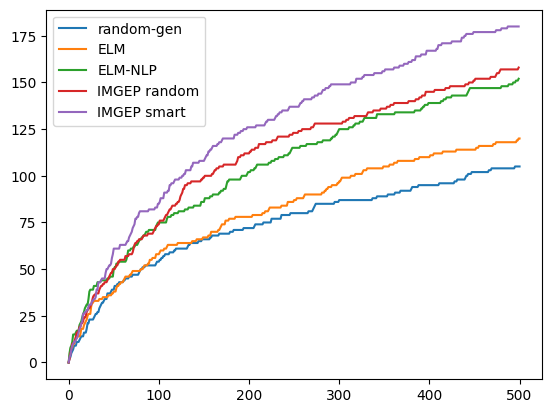

In [19]:
# include_trainset=False


# #plo
# number_of_cells_filled_b0=return_cells_filled_per_gen_map_elite(rd_gen,include_trainset=include_trainset)#,max_gen=300)
# number_of_cells_filled_b1=return_cells_filled_per_gen_map_elite(elm,include_trainset=include_trainset)#,max_gen=300)

# number_of_cells_filled_b2=return_cells_filled_per_gen_map_elite(elm_NLP,include_trainset=include_trainset)#,max_gen=300)
# idx_m=-1#len(number_of_cells_filled_b2)+100
# number_of_cells_filled_b3=return_cells_filled_per_gen_map_elite(imgep_random,include_trainset=include_trainset)#,max_gen=300)
# number_of_cells_filled_b4=return_cells_filled_per_gen_map_elite(imgep_smart,include_trainset=include_trainset)#,max_gen=300)
# plt.plot(number_of_cells_filled_b0)
# plt.plot(number_of_cells_filled_b1)

# plt.plot(number_of_cells_filled_b2[:idx_m])
# plt.plot(number_of_cells_filled_b3[:idx_m])
# plt.plot(number_of_cells_filled_b4[:idx_m])
# plt.legend(list_legend)

1451
3073
2082
2389
2250


Text(0.5, 1.0, 'Number of niches filled per generation \n in a Natural Language Embedding space\n')

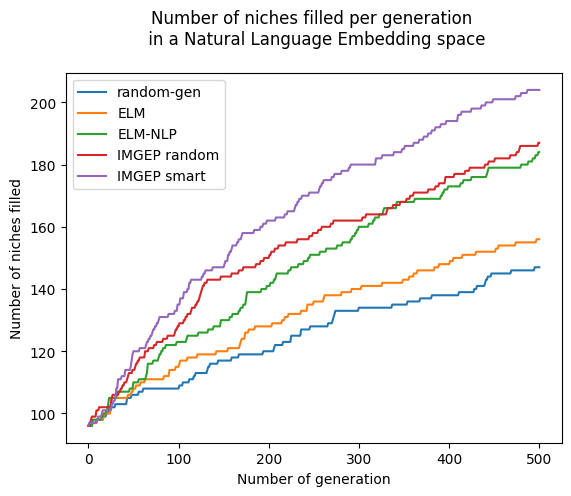

In [4]:
include_trainset=True

number_of_cells_filled_b0=return_cells_filled_per_gen_map_elite(rd_gen,include_full_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b1=return_cells_filled_per_gen_map_elite(elm,include_full_trainset=include_trainset)#,max_gen=300)

number_of_cells_filled_b2=return_cells_filled_per_gen_map_elite(elm_NLP,include_full_trainset=include_trainset)#,max_gen=300)
idx_m=-1#len(number_of_cells_filled_b2)+100
number_of_cells_filled_b3=return_cells_filled_per_gen_map_elite(imgep_random,include_full_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b4=return_cells_filled_per_gen_map_elite(imgep_smart,include_full_trainset=include_trainset)#,max_gen=300)
plt.plot(number_of_cells_filled_b0)
plt.plot(number_of_cells_filled_b1)

plt.plot(number_of_cells_filled_b2)
plt.plot(number_of_cells_filled_b3)
plt.plot(number_of_cells_filled_b4)
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(list_legend)
plt.title("Number of niches filled per generation \n in a Natural Language Embedding space\n")

In [29]:
c=return_cells_filled_per_gen_map_elite(imgep_smart,include_full_trainset=include_trainset)#,max_gen=300)


2250


2748
2341


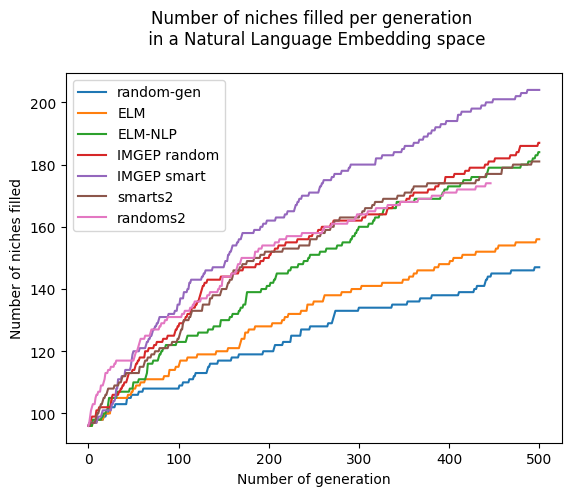

In [12]:
include_trainset=True
imgep_smart_seed_2="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_smart/23-09-14_20:23/step_499/"#"/media/data/flowers/OpenELM/logs/elm/23-09-13_19:06/step_170/"

imgep_random_seed_2="/media/data/flowers/OpenELM/logs/elm/env=p3_probsol_Chat_IMGEP_random/23-09-14_20:24/step_445/"

smarts2=return_cells_filled_per_gen_map_elite(imgep_smart_seed_2,include_full_trainset=include_trainset)#,max_gen=300)
randoms2=return_cells_filled_per_gen_map_elite(imgep_random_seed_2,include_full_trainset=include_trainset)#,max_gen=300)
plt.plot(number_of_cells_filled_b0)
plt.plot(number_of_cells_filled_b1)

plt.plot(number_of_cells_filled_b2)
plt.plot(number_of_cells_filled_b3)
plt.plot(number_of_cells_filled_b4)
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(list_legend)
plt.title("Number of niches filled per generation \n in a Natural Language Embedding space\n")
plt.plot(smarts2)
plt.plot(randoms2)
plt.legend(list_legend+["smarts2","randoms2"])
# plt.xlim(right=50)

In [14]:
elmseed1="/media/data/flowers/OpenELM/logs/elm/env=P3ProbSolChatEnv_ELM,qd=cvtmapelites/23-09-13_23:04/step_499/"
elmsd1=return_cells_filled_per_gen_map_elite(elmseed1,include_full_trainset=include_trainset)#,max_gen=300)


3217


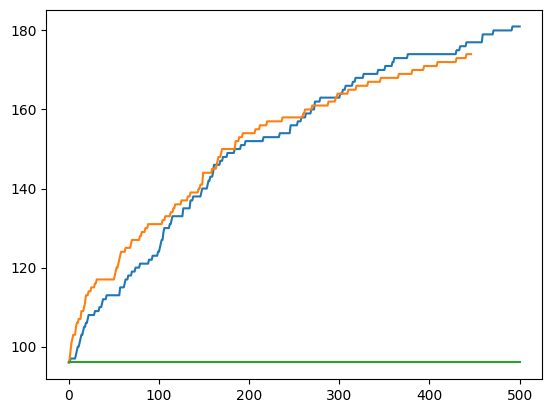

In [15]:
plt.plot(smarts2)
plt.plot(randoms2)
plt.plot(elmsd1)

## emb space

100%|██████████| 1577/1577 [00:13<00:00, 118.61it/s]


319 1258


100%|██████████| 3028/3028 [00:24<00:00, 123.36it/s]


532 2496


100%|██████████| 2079/2079 [00:18<00:00, 109.80it/s]


346 1733


100%|██████████| 2396/2396 [00:28<00:00, 85.24it/s]


381 2015


100%|██████████| 2301/2301 [00:27<00:00, 82.37it/s]


405 1896


100%|██████████| 536/536 [00:05<00:00, 100.27it/s]


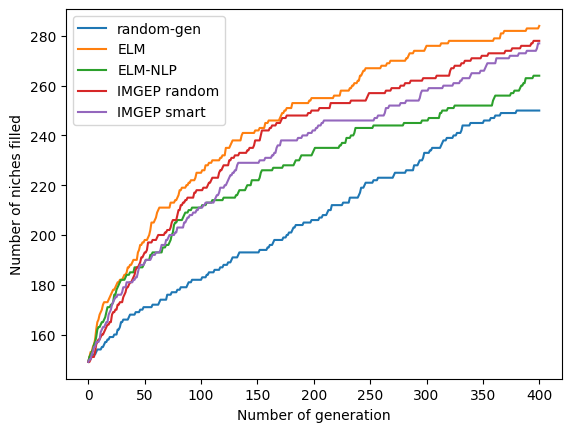

In [11]:
include_full_trainset=True
number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(rd_gen,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(elm,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(elm_NLP,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(imgep_random,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(imgep_smart,path_centroids,include_full_trainset=include_full_trainset)

plt.plot(number_of_cvt_cells_filled_b0)
plt.plot(number_of_cvt_cells_filled_b1)
plt.plot(number_of_cvt_cells_filled_b2)
plt.plot(number_of_cvt_cells_filled_b3)
plt.plot(number_of_cvt_cells_filled_b4)
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])

## other embeddings model

In [15]:
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_compute_dtype=torch.float16
)
# embedding_model_path = "Salesforce/codegen-350M-mono"#"Salesforce/codegen2-1B" #"flax-sentence-embeddings/st-codesearch-distilroberta-base"#"Salesforce/codegen-350M-mono"
# pl = pipeline("feature-extraction", model=embedding_model_path,device_map="auto",trust_remote_code=True,
#               quantization_config=quantization_config
#               )

model_id= "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto",quantization_config=quantization_config)
# inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
# emb = model(inputs.to("cuda"))[0]
# emb=emb.to("cpu").numpy()


## model without pipeline

In [1]:
3//2

1

In [2]:
from sklearn.cluster import KMeans
list_emb_cod5p=[]
path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
list_emb=[]
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]
        inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
        emb = model(inputs.to("cuda"))[0]
        emb=emb.to("cpu").numpy()
        # emb=features.mean(axis=1).flatten()
        list_emb.append(emb)
list_emb=np.array(list_emb)
n_vect2add= 42_000 #- len(list_emb)

liste_choice=np.random.choice(len(list_emb), n_vect2add,replace= True)
embed2nois = list_emb[liste_choice]
scale=0.5
noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
noisy_embed = embed2nois + noise  # add noise to embeddings
noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
for scale in tqdm([0.1]*10):
    noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
    noisy_embed = embed2nois + noise  # add noise to embeddings
    noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
    points = noisy_embed
    # points = np.vstack((list_emb,noisy_embed))

    k_means = KMeans(init="k-means++", n_init="auto", n_clusters=1024,random_state=42)
    k_means.fit(points)
    centroids = k_means.cluster_centers_
    include_full_trainset=True
    number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(
        rd_gen,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(
        elm,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(
        elm_NLP,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_random,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_smart,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    list_emb_cod5p.append([number_of_cvt_cells_filled_b0,number_of_cvt_cells_filled_b1,number_of_cvt_cells_filled_b2,number_of_cvt_cells_filled_b3,number_of_cvt_cells_filled_b4])
    plt.plot(number_of_cvt_cells_filled_b0)
    plt.plot(number_of_cvt_cells_filled_b1)
    plt.plot(number_of_cvt_cells_filled_b2)
    plt.plot(number_of_cvt_cells_filled_b3)
    plt.plot(number_of_cvt_cells_filled_b4)
    plt.ylabel("Number of niches filled")
    plt.xlabel("Number of generation")
    plt.legend(["ELM", "IMGEP smart"])

    plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])
    plt.title(f"niched filled over generation with {model_id} noise scale = {scale}\n")
    plt.show()

NameError: name 'json' is not defined

In [19]:
list_run=[[] for _ in range(5)]

from sklearn.cluster import KMeans
list_emb_cod5p=[]

path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
list_emb=[]
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]
        inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
        emb = model(inputs.to("cuda"))[0]
        emb=emb.to("cpu").numpy()
        # emb=features.mean(axis=1).flatten()
        list_emb.append(emb)
list_emb=np.array(list_emb)
n_vect2add= 42_000 #- len(list_emb)
liste_choice=np.random.choice(len(list_emb), n_vect2add,replace= True)
embed2nois = list_emb[liste_choice]
scale=0.5
noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
noisy_embed = embed2nois + noise  # add noise to embeddings
noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
for scale in tqdm([1]*5):
    noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
    noisy_embed = embed2nois + noise  # add noise to embeddings
    noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
    points = noisy_embed
    # points = np.vstack((list_emb,noisy_embed))

    k_means = KMeans(init="k-means++", n_init="auto", n_clusters=1024,random_state=42)
    k_means.fit(points)
    centroids = k_means.cluster_centers_
    include_full_trainset=True
    number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(
        rd_gen,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(
        elm,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(
        elm_NLP,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_random,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_smart,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    list_run[0].append(number_of_cvt_cells_filled_b0)
    list_run[1].append(number_of_cvt_cells_filled_b1)
    list_run[2].append(number_of_cvt_cells_filled_b2)
    list_run[3].append(number_of_cvt_cells_filled_b3)
    list_run[4].append(number_of_cvt_cells_filled_b4)

100%|██████████| 1770/1770 [00:24<00:00, 73.58it/s]


1451


100%|██████████| 3600/3600 [00:50<00:00, 71.98it/s]


3073


100%|██████████| 2428/2428 [00:34<00:00, 70.15it/s]


2082


100%|██████████| 2754/2754 [00:38<00:00, 71.31it/s]


2389


100%|██████████| 2633/2633 [00:37<00:00, 69.46it/s]


2250


100%|██████████| 1770/1770 [00:25<00:00, 69.50it/s]


1451


100%|██████████| 3600/3600 [00:50<00:00, 71.62it/s]


3073


100%|██████████| 2428/2428 [00:32<00:00, 75.73it/s]


2082


100%|██████████| 2754/2754 [00:37<00:00, 73.23it/s]


2389


100%|██████████| 2633/2633 [00:36<00:00, 73.05it/s]


2250


100%|██████████| 1770/1770 [00:25<00:00, 70.03it/s]


1451


100%|██████████| 3600/3600 [00:51<00:00, 69.35it/s]


3073


100%|██████████| 2428/2428 [00:34<00:00, 69.91it/s]


2082


100%|██████████| 2754/2754 [00:38<00:00, 70.85it/s]


2389


100%|██████████| 2633/2633 [00:38<00:00, 68.28it/s]


2250


100%|██████████| 1770/1770 [00:24<00:00, 71.68it/s]


1451


100%|██████████| 3600/3600 [00:51<00:00, 69.82it/s]


3073


100%|██████████| 2428/2428 [00:35<00:00, 68.84it/s]


2082


100%|██████████| 2754/2754 [00:42<00:00, 64.90it/s]


2389


100%|██████████| 2633/2633 [00:39<00:00, 66.97it/s]


2250


100%|██████████| 1770/1770 [00:24<00:00, 72.41it/s]


1451


100%|██████████| 3600/3600 [00:52<00:00, 69.12it/s]


3073


100%|██████████| 2428/2428 [00:35<00:00, 68.94it/s]


2082


100%|██████████| 2754/2754 [00:40<00:00, 68.08it/s]


2389


100%|██████████| 2633/2633 [00:38<00:00, 68.33it/s]


2250


100%|██████████| 5/5 [20:01<00:00, 240.35s/it]


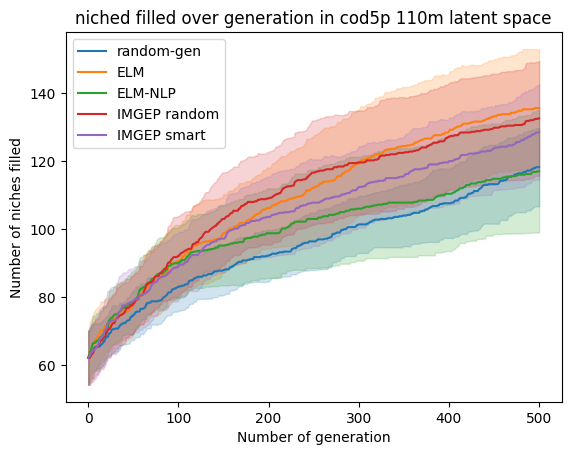

In [20]:
leg=["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]
for i in range(len(list_run)):
    data = np.array(list_run[i])

    # Calculate the mean and standard deviation along the 0th axis (i.e., for each column)
    means = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)

    # Create an x-axis range based on the length of one of the inner lists
    x = range(len(list_run[i][0]))

    # Plot the means with error bars representing the standard deviation
    line, = plt.plot(x, means, label=leg[i])

# Get the color of the mean line
    line_color = line.get_color()
    plt.fill_between(x, means - std_dev, means + std_dev, color=line_color, alpha=0.2)

    # plt.errorbar(x, means, yerr=std_dev, capsize=5, label=leg[i])
  

plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")

plt.legend()
plt.title(f"niched filled over generation in cod5p 110m latent space") 
plt.savefig("/media/data/flowers/OpenELM/fig/cod5p_110m_noise_scale_1.pdf")
plt.show()

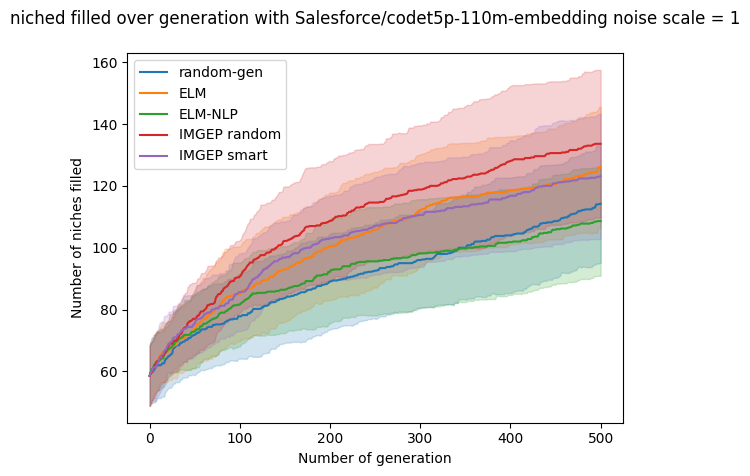

In [23]:
leg=["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]
for i in range(len(list_run)):
    data = np.array(list_run[i])

    # Calculate the mean and standard deviation along the 0th axis (i.e., for each column)
    means = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)

    # Create an x-axis range based on the length of one of the inner lists
    x = range(len(list_run[i][0]))

    # Plot the means with error bars representing the standard deviation
    line, = plt.plot(x, means, label=leg[i])

# Get the color of the mean line
    line_color = line.get_color()
    plt.fill_between(x, means - std_dev, means + std_dev, color=line_color, alpha=0.2)

    # plt.errorbar(x, means, yerr=std_dev, capsize=5, label=leg[i])
  

plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")

plt.legend()
plt.title(f"niched filled over generation in cod5p 110m latent space") 
plt.savefig("/media/data/flowers/OpenELM/fig/cod5p_110m_noise_scale_1.pdf")
plt.show()

### model with pipeline

## number of example generated / generation

# example of puzzle

In [6]:
path_map ="/media/data/flowers/OpenELM/run_saved/imgep_smart/step_499_1/"
# with open(path_map, "rb") as f:
    # maps = pickle.load(f)
    # 
# all_item=getallitems(maps)
idx_max=500
idx=[i for i in range(idx_max)]
for path_map in [path_map,full_list_path_seed1[-1]]:
    with open(path_map+"/maps.pkl", "rb") as f:
        maps = pickle.load(f)
    all_item=getallitems(maps)
    list_gen=[puzz.idx_generation for puzz in all_item] 

In [20]:

count=0
for i in range((len(all_item))):
    if "assert f(g()) == True" in all_item[i].program_str or "assert f(*g()) == True" in all_item[i].program_str:#all_item[i].idx_generation>50 and :
        print("=====")
        print(all_item[i].idx_generation)
        print(all_item[i].program_str)
        count+=1
print(count)

=====
47
from typing import*
from typing import List

def f(grid: List[List[int]]) -> bool:
    """
    Given a grid of 0s and 1s, determine if it is possible to reach from the top-left corner to the bottom-right corner.
    You can only move down or right.
    Return True if it is possible, False otherwise.
    """
    m = len(grid)
    n = len(grid[0])
    
    stack = [(0, 0)]
    
    while stack:
        x, y = stack.pop()
        
        if x == m-1 and y == n-1:
            return True
        
        if x+1 < m and grid[x+1][y] == 0:
            stack.append((x+1, y))
        
        if y+1 < n and grid[x][y+1] == 0:
            stack.append((x, y+1))
    
    return False


def g():
    grid = [
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0]
    ]
    return grid

assert f(g()) == True

=====
0
from typing import*
from collections import deque

def f(s: str) -> bool:
    """Check if a given string is a palindrome."""
    stack = deque

In [16]:
1^3

2

In [ ]:
# "bad" puzzles (give answer in f)
def f(s: str, grid: List[List[str]]) -> bool:
    """
    Given a string s and a grid of characters, determine if it is possible to form the string s by traversing the grid horizontally or vertically in a continuous path.
    Return True if the string can be formed, False otherwise.

    Example:
    s = "HELLO"
    grid = [['H', 'E', 'L'],
            ['L', 'O', 'L']]

    f(s, grid) => True
    Explanation: The string "HELLO" can be formed by traversing the grid horizontally and vertically.

    """

    rows = len(grid)
    cols = len(grid[0])

    def dfs(row, col, index):
        if index == len(s):
            return True
        if row < 0 or row >= rows or col < 0 or col >= cols or s[index] != grid[row][col]:
            return False

        temp = grid[row][col]
        grid[row][col] = '#'

        result = dfs(row + 1, col, index + 1) or dfs(row - 1, col, index + 1) or dfs(row, col + 1, index + 1) or dfs(row, col - 1, index + 1)

        grid[row][col] = temp

        return result

    for row in range(rows):
        for col in range(cols):
            if dfs(row, col, 0):
                return True

    return False

def g():
    return "HELLO", [['H', 'E', 'L'],
                     ['L', 'O', 'L']]

assert f(*g()) == True
# solution is given in the assert
from typing import List

def f(grid: List[List[int]]) -> int:
    """
    Given a grid of non-negative integers, find the maximum sum of a path from the top-left corner to the bottom-right corner.
    You can only move down or right in the grid.
    """
    rows = len(grid)
    cols = len(grid[0])
    
    dp = [[0] * cols for _ in range(rows)]
    
    dp[0][0] = grid[0][0]
    
    for i in range(1, rows):
        dp[i][0] = dp[i-1][0] + grid[i][0]
    
    for j in range(1, cols):
        dp[0][j] = dp[0][j-1] + grid[0][j]
    
    for i in range(1, rows):
        for j in range(1, cols):
            dp[i][j] = max(dp[i-1][j], dp[i][j-1]) + grid[i][j]
    
    return dp[rows-1][cols-1]

def g():
    grid = [
        [1, 3, 1],
        [1, 5, 1],
        [4, 2, 1]
    ]
    return grid

assert f(g()) == 12


In [14]:
from typing import List

def f(grid: List[List[int]]) -> int:
    """
    Given a grid representing a maze, return the minimum number of steps required to reach the destination from the starting point.
    You can only move in four directions: up, down, left, and right. The value 1 represents a valid path, while 0 represents a wall.
    """
    rows = len(grid)
    cols = len(grid[0])
    
    def bfs(start_row: int, start_col: int) -> int:
        queue = [(start_row, start_col, 0)]
        visited = set()
        
        while queue:
            row, col, steps = queue.pop(0)
            if (row, col) == (rows-1, cols-1):
                return steps
            
            if (row, col) in visited:
                continue
            visited.add((row, col))
            
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                new_row = row + dx
                new_col = col + dy
                if 0 <= new_row < rows and 0 <= new_col < cols and grid[new_row][new_col] == 1:
                    queue.append((new_row, new_col, steps+1))
        
        return -1
    
    return bfs(0, 0)

def g() -> List[List[int]]:
    grid = [[1, 1, 1, 1, 1],
            [0, 0, 1, 0, 1],
            [1, 1, 1, 1, 1],
            [1, 0, 0, 0, 1],
            [1, 1, 1, 1, 1],]
    return grid

f(g())


9

2454
2633


/tmp/ipykernel_17229/727018474.py:17: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("seed2","seed1")


Text(0.5, 1.0, 'evolution of the number of correct puzzle generated ')

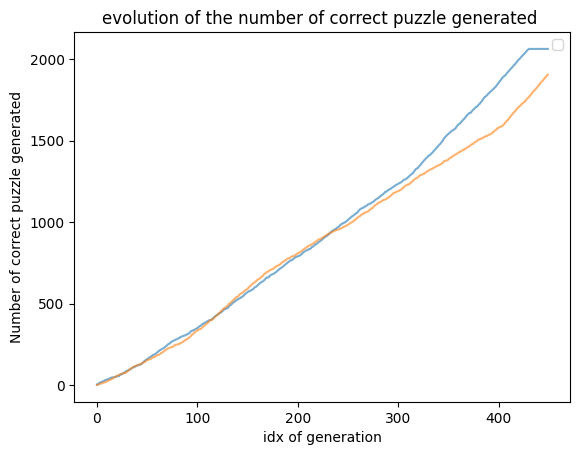

In [53]:
path_map ="/media/data/flowers/OpenELM/logs/elm/23-09-05_15:31/step_430/"
# with open(path_map, "rb") as f:
    # maps = pickle.load(f)
    # 
# all_item=getallitems(maps)
idx_max=450
idx=[i for i in range(idx_max)]
for path_map in [path_map,full_list_path_seed1[-1]]:
    with open(path_map+"/maps.pkl", "rb") as f:
        maps = pickle.load(f)
    all_item=getallitems(maps)
    list_gen=[puzz.idx_generation for puzz in all_item] 
    print(len(list_gen))
    count_item_gen=[list_gen.count(i) for i in range(idx_max)]
    evolution_numb_puzz = np.cumsum(count_item_gen)
    plt.plot(idx,evolution_numb_puzz,alpha=0.6)
plt.legend("seed2","seed1")
plt.xlabel("idx of generation")
plt.ylabel("Number of correct puzzle generated")
plt.title('evolution of the number of correct puzzle generated ')

In [49]:
full_list_path_seed1[-1]

['random-gen', 'ELM', 'ELM-NLP', 'IMGEP random', 'IMGEP smart']

Text(0.5, 1.0, 'evolution of the number of correct puzzle generated ')

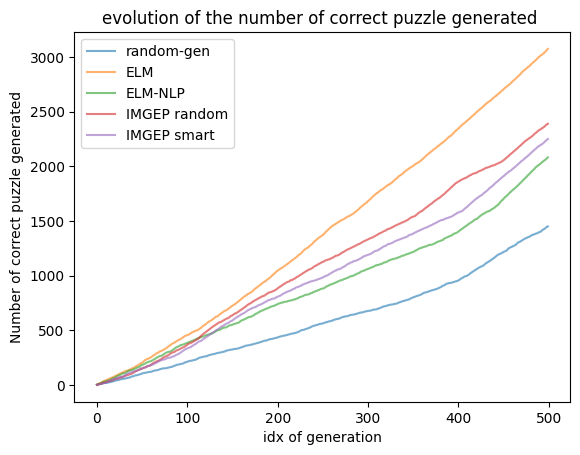

In [36]:
path_map ="/media/data/flowers/OpenELM/run_saved/elm/step_399_1/maps.pkl"
with open(path_map, "rb") as f:
    maps = pickle.load(f)
    
all_item=getallitems(maps)
idx_max=500
idx=[i for i in range(idx_max)]
for path_map in full_list_path_seed1:
    with open(path_map+"/maps.pkl", "rb") as f:
        maps = pickle.load(f)
    all_item=getallitems(maps)
    list_gen=[puzz.idx_generation for puzz in all_item] 
    count_item_gen=[list_gen.count(i) for i in range(idx_max)]
    evolution_numb_puzz = np.cumsum(count_item_gen)
    plt.plot(idx,evolution_numb_puzz,alpha=0.6)
plt.legend(list_legend)
plt.xlabel("idx of generation")
plt.ylabel("Number of correct puzzle generated")
plt.title('evolution of the number of correct puzzle generated ')

# diversity measure

## distance nearest neighb

In [34]:
from transformers import BitsAndBytesConfig
from tqdm import tqdm
quantization_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_compute_dtype=torch.float16
)
model_id = "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto",quantization_config=quantization_config)
# model=torch.compile(model)


embedding_model_path = "Salesforce/codegen-350M-mono"#"Salesforce/codegen2-1B" #"flax-sentence-embeddings/st-codesearch-distilroberta-base"#"Salesforce/codegen-350M-mono"
pl = pipeline("feature-extraction", model=embedding_model_path,device_map="auto",trust_remote_code=True,
              quantization_config=quantization_config
              )


# pipeline

In [35]:
with torch.no_grad():
    # list_legend = ["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]
    all_items_gen=[]
    for path in full_list_path_seed1:
        path_maps = path + "maps.pkl"
        with open(path_maps, "rb") as f:
            maps = pickle.load(f)
        allitems=getallitems(maps)
        items_gen = [item for item in allitems if item.idx_generation!=-1]
        for puzz in tqdm(items_gen):
            # inputs = tokenizer.encode(puzz.program_str, return_tensors="pt",truncation=True,max_length=512)
            features = np.array(pl(puzz.program_str))
            emb=features.mean(axis=1).flatten()
            puzz.emb = emb
        all_items_gen.append(items_gen)
    
    
path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
list_emb_trainset=[]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]
        features = np.array(pl(program_str))
        emb=features.mean(axis=1).flatten()
        list_emb_trainset.append(emb)
        

  1%|          | 8/1451 [00:00<01:02, 23.21it/s]/media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 536/536 [00:33<00:00, 16.19it/s]


# model+emb

In [5]:
with torch.no_grad():
    # list_legend = ["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]
    all_items_gen=[]
    for path in full_list_path_seed1:
        path_maps = path + "maps.pkl"
        with open(path_maps, "rb") as f:
            maps = pickle.load(f)
        allitems=getallitems(maps)
        items_gen = [item for item in allitems if item.idx_generation!=-1]
        for puzz in tqdm(items_gen):
            inputs = tokenizer.encode(puzz.program_str, return_tensors="pt",truncation=True,max_length=512)
            emb = model(inputs.to("cuda"))[0]
            emb = emb.to("cpu").numpy()
            puzz.emb = emb
        all_items_gen.append(items_gen)
    
    
path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
list_emb_trainset=[]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]
        inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
        emb = model(inputs.to("cuda"))[0]
        emb=emb.to("cpu").numpy()
        list_emb_trainset.append(emb)
        

100%|██████████| 536/536 [00:07<00:00, 72.68it/s]


In [111]:
list_all=[]
list_count=[]
list_count_2=[]
min_len=min([len(all_item) for all_item in all_items_gen])
for idx_baseline in range(5):
    list_idx=np.random.choice(min_len,size=min_len,replace=False)

    list_emb_aa=np.array([all_items_gen[idx_baseline][item].emb for item in list_idx])
    list_lab=[list_legend[idx_baseline]]*len(list_emb_aa)
    
    for j in list_lab:
        list_count_2.append(idx_baseline)
        list_count.append(j)
    list_all.append(list_emb_aa)

list_all=np.vstack(list_all)
list_count=np.array(list_count)
list_count_2 = np.array(list_count_2)

array(['random-gen', 'random-gen', 'random-gen', ..., 'IMGEP smart',
       'IMGEP smart', 'IMGEP smart'], dtype='<U12')

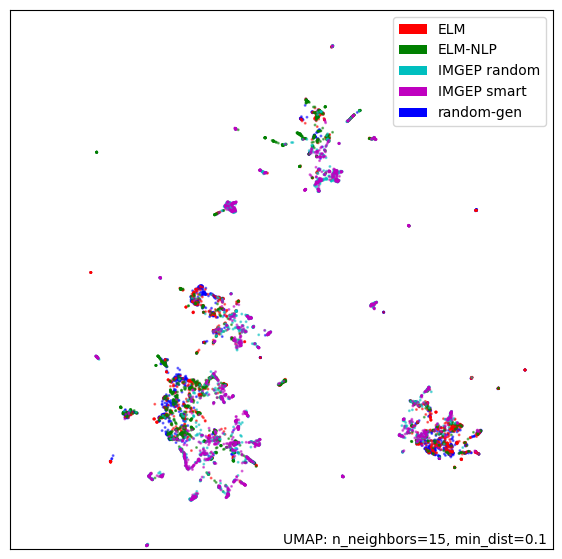

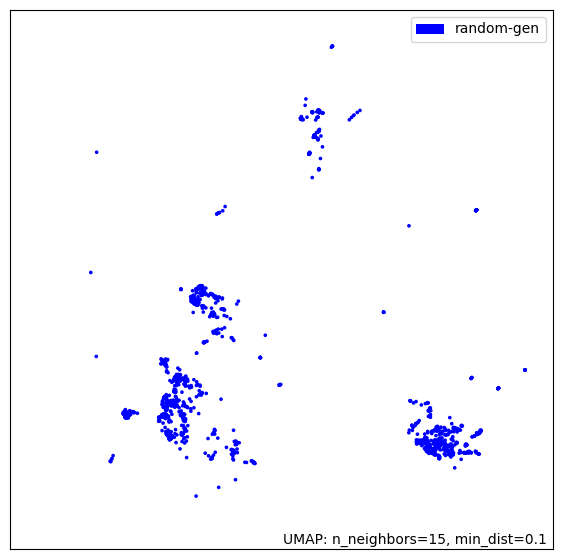

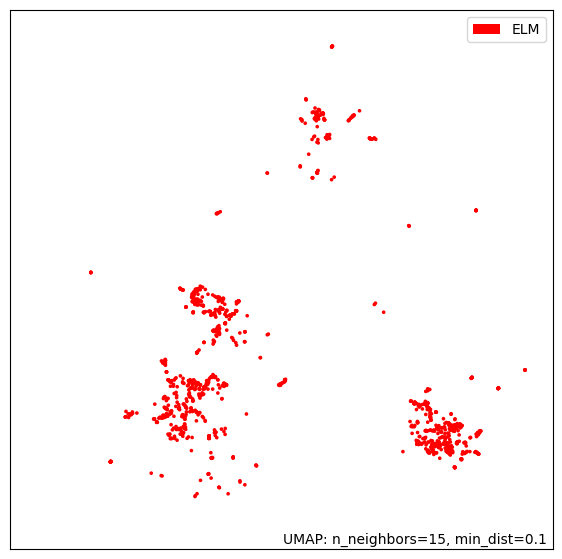

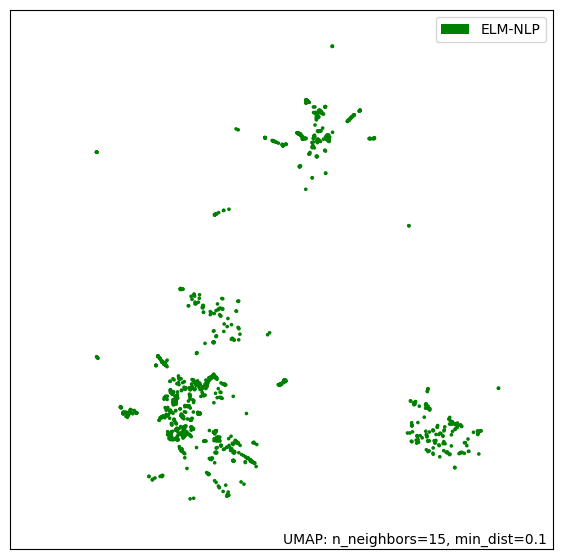

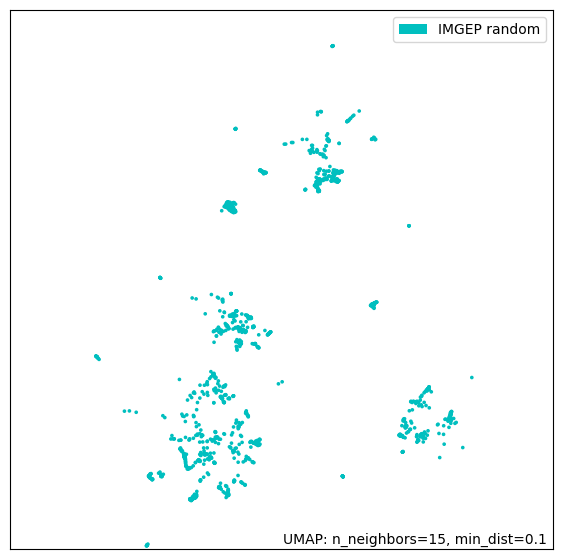

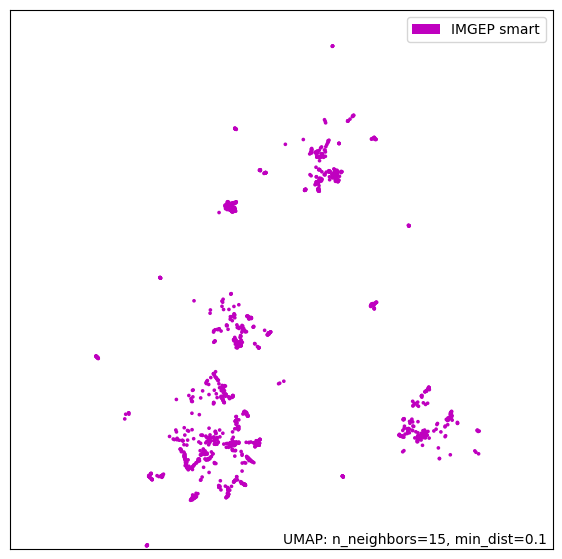

In [144]:


import umap.plot
# trans = umap.UMAP(n_neighbors=15, n_components = 2, random_state=42).fit(list_all)
color_key={}
col=["b","r","g","c", "m"]
color_key = {list_legend[d]: c for d, c in enumerate(col)}

out=umap.plot.points(trans,labels=list_count,alpha=0.5,color_key=color_key,    width=700,   height=700,)#,theme='fire')
out.set_xlim([-9,25])
out.set_ylim([-10,25])
out.figure.savefig("/media/data/flowers/OpenELM/fig/umap_5baselines.pdf")
for idx_bas in range(5):
    subset_points= [list_count_2[i]==idx_bas for i in range(len(list_count)) ]
    out=umap.plot.points(trans,labels=list_count,subset_points=subset_points,color_key={list_legend[idx_bas]: col[idx_bas]},    width=700,   height=700,)#,theme='fire')
    out.set_xlim([-9,25])
    out.set_ylim([-10,25])
    out.figure.savefig("/media/data/flowers/OpenELM/fig/umap_"+list_legend[idx_bas]+".pdf")


In [142]:
out.figure.savefig("/media/data/flowers/OpenELM/fig/umap_5baselines.pdf")


In [ ]:
data = np.vstack((points, list_emb))

# Create labels for points (0) and list_emb_a (1)
labels = np.hstack((np.zeros(len(points)), np.ones(len(list_emb))))

from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)
embedded_points = embedded_data[labels == 0]
embedded_list_emb_a = embedded_data[labels == 1]

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(embedded_points[:, 0], embedded_points[:, 1], color='blue', label='Points')
plt.scatter(embedded_list_emb_a[:, 0], embedded_list_emb_a[:, 1], color='red', label='list_emb_a')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Points and list_emb_a')
plt.legend()

plt.show()

In [61]:
# compared mean dist to prev gen
np.random.seed(42)
_list_emb_trainset=torch.tensor(list_emb_trainset).cuda()
list_values=[[] for _ in range(len(full_list_path_seed1))]
list_n_puzzles=[[] for _ in range(len(full_list_path_seed1))]
list_gen=[[] for _ in range(len(full_list_path_seed1))]

# min_len=min([len(all_item) for all_item in all_items_gen])
# list_idx=np.random.choice(min_len,size=min_len,replace=False)
k=10
for idx_baseline in range(1,len(full_list_path_seed1)):
        items_gen=[all_items_gen[idx_baseline][idx].emb for idx in range(len(all_items_gen[idx_baseline]))]
        # items_gen= torch.tensor(items_gen).to("cuda")
        sum_values=0.
        list_id_gen=[]
        for idx_gen in range(500):
            list_puzz_at_currgen=[item.emb for item in all_items_gen[idx_baseline] if item.idx_generation==idx_gen]
            
            list_emb_2compare=torch.tensor([item.emb for item in all_items_gen[idx_baseline] if item.idx_generation<idx_gen])
            if list_emb_2compare.shape[0]==0:
                to_comp_dist=_list_emb_trainset
            else:
                to_comp_dist=torch.vstack((_list_emb_trainset,list_emb_2compare.cuda()))
            list_puzz_at_currgen= torch.tensor(list_puzz_at_currgen).cuda()
            dist_matr =torch.cdist(list_puzz_at_currgen, to_comp_dist, p=2.0)
            values,_=torch.topk(dist_matr[0,:], k,largest=False)
            values=values[1:].mean().item() #removed dist with itself
            sum_values+=values
        list_values[idx_baseline].append(sum_values)
        # list_n_puzzles[]

RuntimeError: cdist only supports at least 2D tensors, X1 got: 1D

### avg dist between emb

In [44]:
np.random.seed(42)
_list_emb_trainset=torch.tensor(list_emb_trainset).cuda()
list_values=[[] for _ in range(len(full_list_path_seed1))]
min_len=min([len(all_item) for all_item in all_items_gen])
list_idx=np.random.choice(min_len,size=min_len,replace=False)
for k in tqdm(range(1,min_len,10)):
    for idx_baseline in range(len(full_list_path_seed1)):
        
        
        items_gen=[all_items_gen[idx_baseline][idx].emb for idx in list_idx]
        items_gen= torch.tensor(items_gen).to("cuda")
        sum_values=0.
        items_gen =torch.vstack((items_gen,_list_emb_trainset))

        dist_matr=torch.cdist(items_gen, items_gen, p=2.0)

        values,_=torch.topk(dist_matr, k+1,largest=False)

        values=values[:,1:].mean().item() #removed dist with itself
        sum_values+=values
        list_values[idx_baseline].append(values)

100%|██████████| 145/145 [01:44<00:00,  1.39it/s]


In [50]:
list_v_train=[]
for k in tqdm(range(1,536,10)):
    dist_matr=torch.cdist(torch.tensor(list_emb_trainset), torch.tensor(list_emb_trainset), p=2.0)

    values,_=torch.topk(dist_matr, k+1,largest=False)
    values=values[:,1:].mean().item() #removed dist with itself
    list_v_train.append(values)

100%|██████████| 54/54 [00:04<00:00, 11.70it/s]


In [39]:
# import copy
# list_values_full =copy.deepcopy(list_values)

Text(0, 0.5, 'mean distance to K-NN')

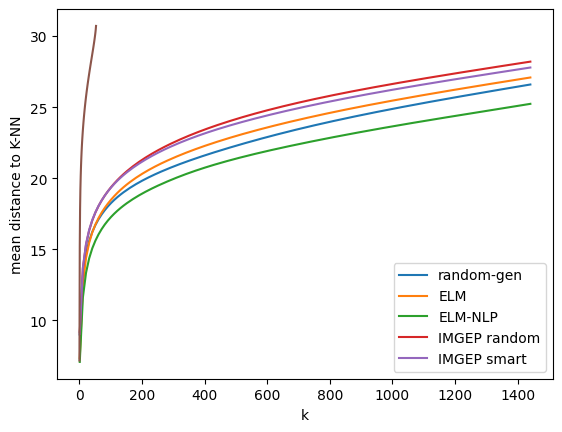

In [54]:
list_k= [i for i in range(1,min_len,10)]
for i in list_values:
    plt.plot(list_k,i)
plt.plot(list_v_train)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.xlim(0,50)

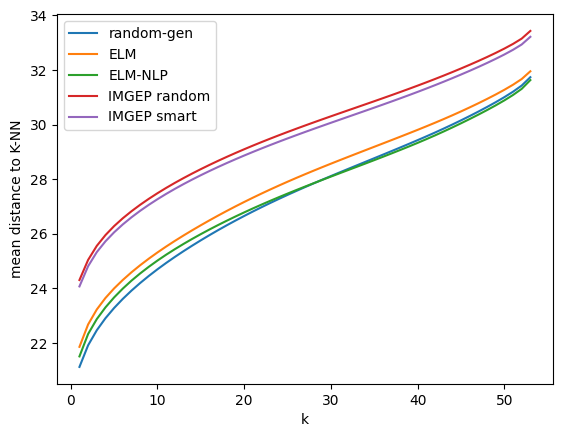

In [147]:

list_k= [i for i in range(1,min_len,10)]
for i in list_values:
    plt.plot(i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.xlim(0,50)
plt.savefig("/media/data/flowers/OpenELM/fig/mean_distance_codegen350mono.pdf")

ValueError: x and y must have same first dimension, but have shapes (145,) and (54,)

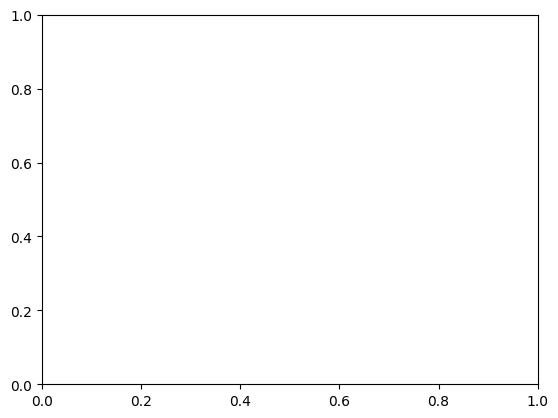

In [146]:
list_k= [i for i in range(1,min_len,10)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
plt.xlim(0,50)
# plt.savefig("/media/data/flowers/OpenELM/fig/mean_distance_codegen350mono.pdf")

Text(0, 0.5, 'mean distance to K-NN')

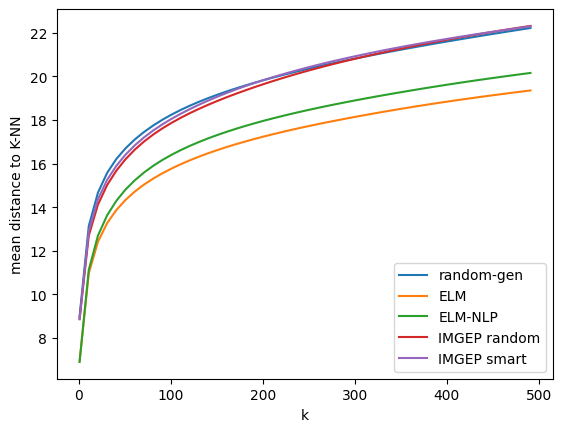

In [37]:
list_k= [i for i in range(1,500,10)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset_codegen350mono.pdf")

In [12]:
k=2
dist_matr=torch.cdist(items_gen, items_gen, p=2.0)
values,_=torch.topk(dist_matr, k+1,largest=False)


torch.Size([1451, 2])

In [13]:
values

tensor([[0.0000, 0.4224],
        [0.0000, 0.5752],
        [0.0000, 0.2891],
        ...,
        [0.0000, 0.2014],
        [0.0000, 0.3164],
        [0.0000, 0.1169]], device='cuda:0', dtype=torch.float16)

In [55]:
np.random.seed(42)
_list_emb_trainset=torch.tensor(list_emb_trainset).cuda()
list_values=[[] for _ in range(len(full_list_path_seed1))]
min_len=min([len(all_item) for all_item in all_items_gen])
list_idx=np.random.choice(min_len,size=min_len,replace=False)
for k in tqdm(range(1,len(_list_emb_trainset),10)):
    for idx_baseline in range(len(full_list_path_seed1)):
        
        
        items_gen=[all_items_gen[idx_baseline][idx].emb for idx in list_idx]#range(min_len)]
        items_gen= torch.tensor(items_gen).to("cuda")
        sum_values=0.
        for idx_ in range(items_gen.shape[0]):
            to_comp_dist=torch.vstack((items_gen[idx_],_list_emb_trainset))

            dist_matr =torch.cdist(to_comp_dist[:1], to_comp_dist[1:], p=2.0)
            values,_=torch.topk(dist_matr[0,:], k,largest=False)
            values=values[1:].mean().item() #removed dist with itself
            sum_values+=values
        list_values[idx_baseline].append(sum_values)

100%|██████████| 54/54 [01:50<00:00,  2.05s/it]


In [64]:
for i in range(len(list_values)):
    for j in range(len(list_values[i])):
        list_values [i][j]=list_values [i][j]/min_len

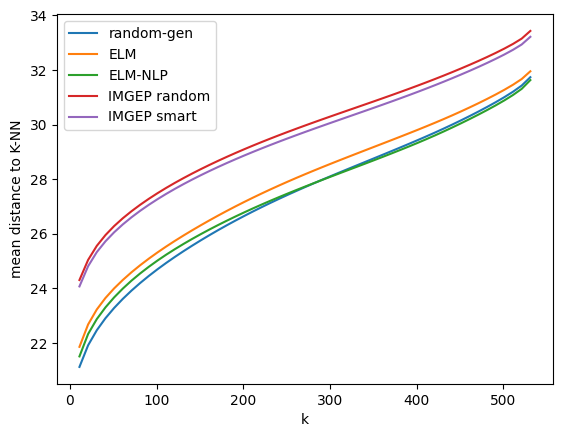

In [66]:
list_k= [i for i in range(1,len(_list_emb_trainset),10)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset_codegen350mono.pdf")

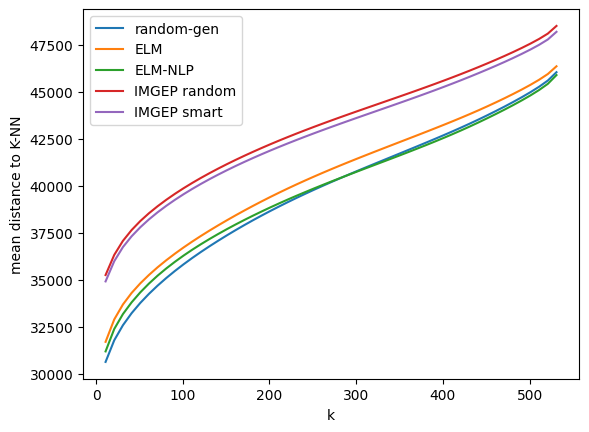

In [40]:
list_k= [i for i in range(1,len(_list_emb_trainset),10)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset_codegen350mono.pdf")

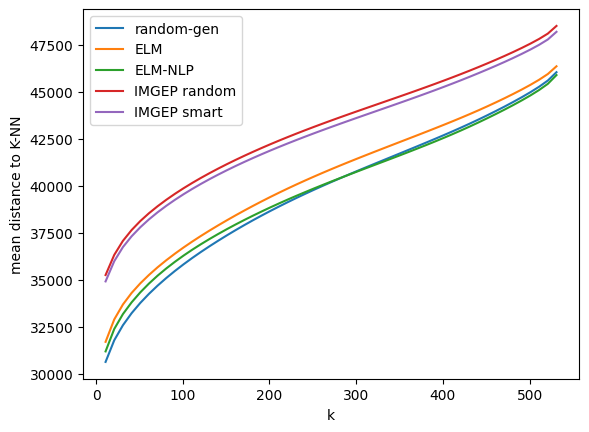

In [28]:
list_k= [i for i in range(1,len(_list_emb_trainset),10)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset_codegen350mono.pdf")

# mean of k nearest neighb compared to trainest 

Text(0.5, 1.0, 'distance between generated dataset and K-NN from trainset')

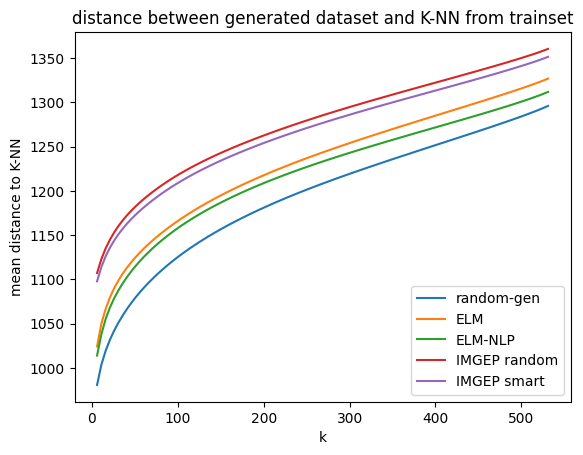

In [29]:
list_k= [i for i in range(1,len(_list_emb_trainset),5)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.title("distance between generated dataset and K-NN from trainset")
plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset.pdf")

# k fartherst

In [30]:
_list_emb_trainset=torch.tensor(list_emb_trainset).cuda()
list_values=[[] for _ in range(len(full_list_path_seed1))]
for k in tqdm(range(1,len(_list_emb_trainset),5)):
    for idx_baseline in range(len(full_list_path_seed1)):
        
        items_gen=[all_items_gen[idx_baseline][idx].emb for idx in range(len(all_items_gen[0]))]
        items_gen= torch.tensor(items_gen).to("cuda")
        sum_values=0.
        for idx_ in range(items_gen.shape[0]):
            to_comp_dist=torch.vstack((items_gen[idx_],_list_emb_trainset))

            dist_matr =torch.cdist(to_comp_dist[:1], to_comp_dist[1:], p=2.0)
            values,_=torch.topk(dist_matr[0,:], k)#,largest=True)
            values=values[1:].mean().item() #removed dist with itself
            sum_values+=values
        list_values[idx_baseline].append(sum_values)


100%|██████████| 107/107 [02:27<00:00,  1.38s/it]


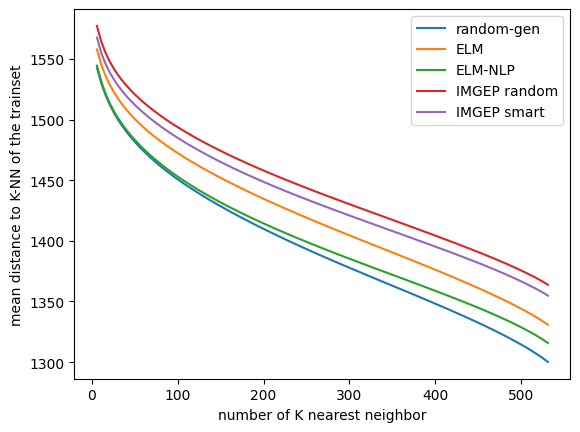

In [34]:
list_k= [i for i in range(1,len(_list_emb_trainset),5)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("number of K nearest neighbor")
plt.ylabel("mean distance to K-NN of the trainset")
# plt.title("distance between generated dataset and K-NN from trainset")
plt.savefig("/media/data/flowers/OpenELM/fig/fartherst_knn_from_trainset.pdf")

# same for testset

## load test

In [ ]:
10 => 16


In [30]:
import ast
import copy
import tiktoken
import json

def return_f(puzzle_json):
    puzzle_json = copy.deepcopy(puzzle_json)
    f = puzzle_json["sat"]
    #  add 'sol_docstring' (description of the problem) to the function f
    f = f.replace("sat(", "f(")
    idx_add_problem_description = f.find("\n")

    if type(puzzle_json["sol_docstring"]) == str:
        f=f[:idx_add_problem_description+1]+ puzzle_json["sol_docstring"]+"\n"+f[idx_add_problem_description+1:]
    return f

def extract_args_f(f):
    """
    extract arguments of f, for g
    """
    str_arg=""
    parsed_ast = ast.parse(f)
    func=parsed_ast.body[0]
    name_args = [a.arg for a in func.args.args][1:] # remove the first arg as it isn't necessary for g (because it is the output return by g)
    assert len(func.args.defaults) == len(name_args)
    for i in range(len(name_args)):
        def_values = ast.literal_eval(func.args.defaults[i])
        if type(def_values) == str:
            def_values = "'"+def_values+"'"
        str_arg += name_args[i] + " = " + str(def_values)
        if i < len(name_args)-1:
            str_arg+=", "
    return str_arg

def add_return_bool_2_f(f):
    tree = ast.parse(f)

    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            node.returns = ast.Name(id='bool', ctx=ast.Load())

    return ast.unparse(tree)


def return_header_g(f):
    args_f = extract_args_f(f)
    return "def g("+args_f+"):"
    
def return_g(puzzle_json,f):
    if puzzle_json["sol_bodies"] == []:
        print("no solution in json")
        return "def g(""):\n    pass"
    args_f = extract_args_f(f)
    g = "def g("+args_f+"):\n"+copy.deepcopy(puzzle_json["sol_bodies"])[0]
    return g

def merge_Q_and_A(liste_fg):
    parsed = copy.deepcopy(liste_fg) # format [(f,g),(f,g),...]

    judge_srcs = [f"{f}\n{g}\nassert f(g())" for (f, g) in parsed] # format the code to be judged
    return judge_srcs


def preprocessing_P3_no_test(split: str = "train", n_token_max: int = 512, load_embedding = False,debug=False) -> list[dict]:
    """
    dl puzzles from P3 dataset and give train or test puzzles
    split = "train" or "test"
    """
    import os
    # os.environ['HF_DATASETS_CACHE'] = "/projets/flowers/julien/hf/datasets"
    # os.environ['TRANSFORMERS_CACHE'] = "/projets/flowers/julien/models/"
    # from transformers import AutoTokenizer
    # model_id="codellama/CodeLlama-7b-Python-hf"
    # # tokenizer = AutoTokenizer.from_pretrained(model_id,trust_remote_code=True)
    import sys 
    sys.set_int_max_str_digits(10_000)
    with open("/media/data/flowers/OpenELM/puzzles.json",mode='r') as f:
        puzzles = json.load(f)
    with open("/media/data/flowers/OpenELM/split.json",mode='r') as f:
        data_split = json.load(f)
    
    
    puzzles_set=[]
    generated_programs=[]
    for i in puzzles:
        if i["name"][:-2] in data_split[split] and i["sol_bodies"]!=[]:
            puzzle_2_add={}
            puzzle_2_add["f"] = add_return_bool_2_f(return_f(i))
            puzzle_2_add["g"] = return_g(i,puzzle_2_add["f"])
            puzzle_2_add['attempts'] = 1 # 
            puzzle_2_add["program_str"] = merge_Q_and_A([(puzzle_2_add["f"],puzzle_2_add["g"])])[0]
            puzzle_2_add["g_firstline"]= return_header_g(puzzle_2_add["f"])
            generated_programs.append(puzzle_2_add["program_str"])
            puzzles_set.append(puzzle_2_add["program_str"])
    
    enc = tiktoken.encoding_for_model("gpt-4")
    List_len_embedding = []
    for puzz in puzzles_set:
        len_puzz=len(enc.encode(puzz))
        # print(len_puzz)
        List_len_embedding.append(len_puzz)
    index=np.array(List_len_embedding)<=n_token_max
    #remove item where index is False
    puzzles_set = [item for i, item in enumerate(puzzles_set) if index[i]]
    print("puzzle found =",len(puzzles_set))
    return puzzles_set

## expe

In [31]:
list_test=preprocessing_P3_no_test( split="test", n_token_max = 512)


puzzle found = 903


In [32]:
list_test[0]

'def f(s: str) -> bool:\n    """Find a string with 1000 \'o\'s, 100 pairs of adjacent \'o\'s and 801 copies of \'ho\'."""\n    return s.count(\'o\') == 1000 and s.count(\'oo\') == 100 and (s.count(\'ho\') == 801)\ndef g():\n    return \'ho\' * (800 + 1) + \'o\' * (100 * 2 - 1)\nassert f(g())'

In [34]:

with torch.no_grad():
    # list_legend = ["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]
    all_items_gen=[]
    for path in full_list_path_seed1:
        path_maps = path + "maps.pkl"
        with open(path_maps, "rb") as f:
            maps = pickle.load(f)
        allitems=getallitems(maps)
        items_gen = [item for item in allitems if item.idx_generation!=-1]
        for puzz in tqdm(items_gen):
            inputs = tokenizer.encode(puzz.program_str, return_tensors="pt",truncation=True,max_length=512)
            emb = model(inputs.to("cuda"))[0]
            emb = emb.to("cpu").numpy()
            puzz.emb = emb
        all_items_gen.append(items_gen)
    
    
list_emb_testset=[]
list_testset=preprocessing_P3_no_test( split="test", n_token_max = 512)
    # list_puzzle_full_trainset["program_str"]
with torch.no_grad():
    for i in tqdm(range(len(list_testset))):
        program_str=list_testset[i]
        inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
        emb = model(inputs.to("cuda"))[0]
        emb=emb.to("cpu").numpy()
        list_emb_testset.append(emb)

100%|██████████| 2250/2250 [00:31<00:00, 70.98it/s]


puzzle found = 903


  0%|          | 0/536 [00:00<?, ?it/s]


TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [44]:
np.random.seed(42)
list_emb_testset=torch.tensor(list_emb_testset).cuda()
list_values=[[] for _ in range(len(full_list_path_seed1))]
min_len=min([len(all_item) for all_item in all_items_gen])
list_idx=np.random.choice(min_len,size=min_len,replace=False)
for k in tqdm(range(1,len(list_emb_testset),10)):
    for idx_baseline in range(len(full_list_path_seed1)):
        
        
        items_gen=[all_items_gen[idx_baseline][idx].emb for idx in list_idx]#range(min_len)]
        items_gen= torch.tensor(items_gen).to("cuda")
        sum_values=0.
        min_val=100000
        for idx_ in range(items_gen.shape[0]):
            to_comp_dist=torch.vstack((items_gen[idx_],list_emb_testset))

            dist_matr =torch.cdist(to_comp_dist[:1], to_comp_dist[1:], p=2.0)
            values,_=torch.topk(dist_matr[0,:], k,largest=False)
            values=values[1:].mean().item() #removed dist with itself
            sum_values+=values
            min_val=min(min_val,values)
        # list_values[idx_baseline].append(sum_values)
        list_values[idx_baseline].append(min_val)

/tmp/ipykernel_17229/655419520.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_emb_testset=torch.tensor(list_emb_testset).cuda()
100%|██████████| 91/91 [02:11<00:00,  1.44s/it]


Text(0, 0.5, 'mean distance to K-NN')

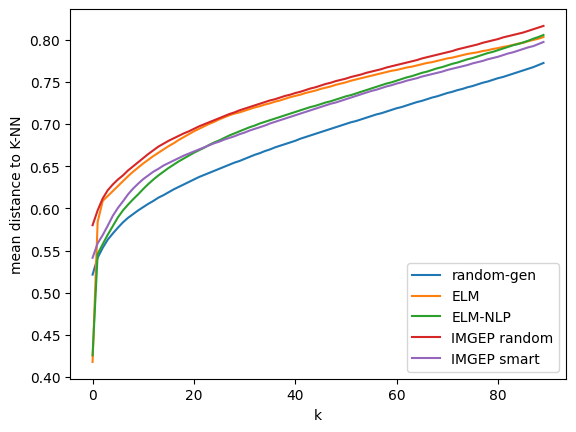

In [46]:
list_k= [i for i in range(1,len(list_testset),10)]
for i in list_values:
    plt.plot(i[1:])
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset_codegen350mono.pdf")

Text(0, 0.5, 'mean distance to K-NN')

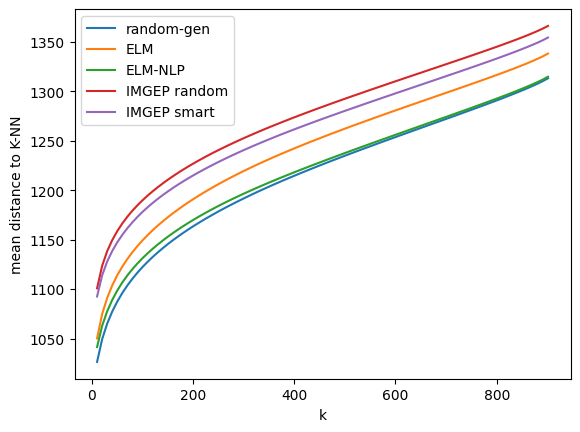

In [41]:
list_k= [i for i in range(1,len(list_testset),10)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
# plt.savefig("/media/data/flowers/OpenELM/fig/nearsest_knn_from_trainset_codegen350mono.pdf")

# label analysis

In [5]:
path_maps=full_list_path_seed1[-1]+"maps.pkl"
with open(path_maps, "rb") as f:
    maps = pickle.load(f)
allitems=getallitems(maps)
items_trainset = [item for item in allitems if item.idx_generation==-1]
items_gen = [item for item in allitems if item.idx_generation!=-1]
len(items_trainset), len(items_gen)

def skill_bool_2idx(skill_targeted):
    return [idx for idx, val in enumerate(skill_targeted) if val]


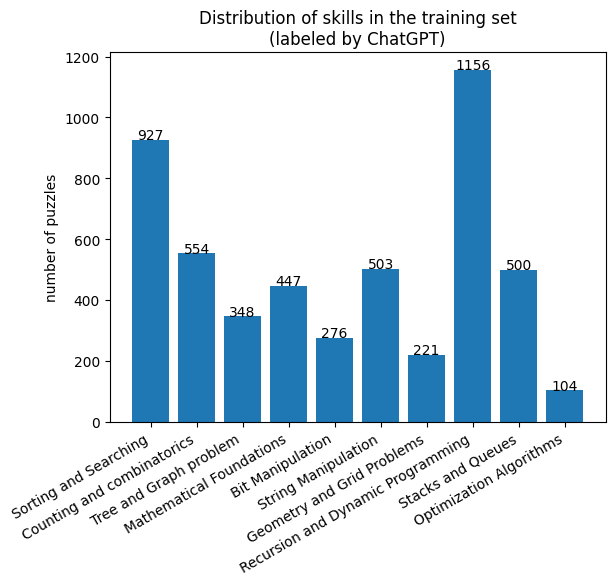

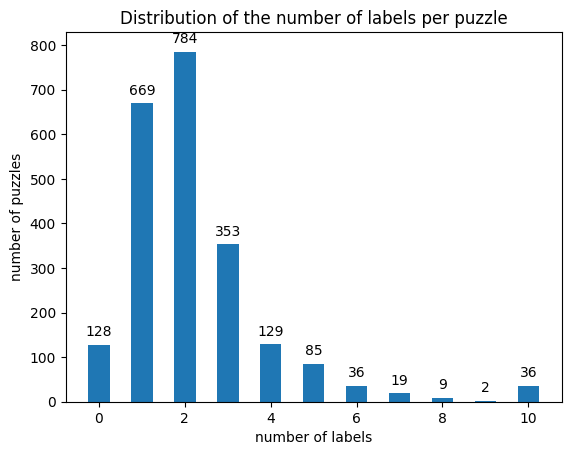

In [10]:

labels = [skill_bool_2idx(i.emb) for i in items_gen]
Label_predicted=labels
# m = [i["program_str"] for i in Labels]
#flatten the labels
labels_flatt = [item for sublist in labels for item in sublist]

# replace xaxis with categories name

categories = skill_list


plt.hist(labels_flatt, bins=range(0, 11), align='left', rwidth=0.8)

# Get the counts of each category
counts = [labels_flatt.count(i) for i in range(len(categories))]

# Add the counts as text on top of each bin
for i, count in enumerate(counts):
    if count > 0:
        plt.text(i, count + 0.85, str(count), ha='center')

# Set the x-axis tick locations and labels
plt.xticks(range(len(categories)), categories, rotation=30, ha='right')
plt.title("Distribution of skills in the training set\n(labeled by ChatGPT)")
# plt.savefig("distribution_labels.pdf")
plt.ylabel("number of puzzles")

plt.savefig("/media/data/flowers/OpenELM/fig/label_distribution0_imgep_smart.pdf",bbox_inches='tight')

plt.show()



set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in Label_predicted]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 20., str(count), ha='center')
# plt.show()
ylim=max(counts_n_label)

# set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
# len_all_label=[len(i) for i in set_of_label_idx]
# counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
# plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# # plt.grid()
# plt.title("Distribution of the number of labels per puzzle (duplicates removed)")
# plt.xlabel("number of labels")
# for i, count in enumerate(counts_n_label):
#     # print(i)
#     if count > 0:
#         plt.text(i, count + 0.15, str(count), ha='center')
plt.ylim(top=ylim+45)
plt.ylabel("number of puzzles")
# plt.legend(["no deduplicate","duplicate"])
plt.savefig("/media/data/flowers/OpenELM/fig/label_distribution1_imgep_smart.pdf",bbox_inches='tight')
plt.show()

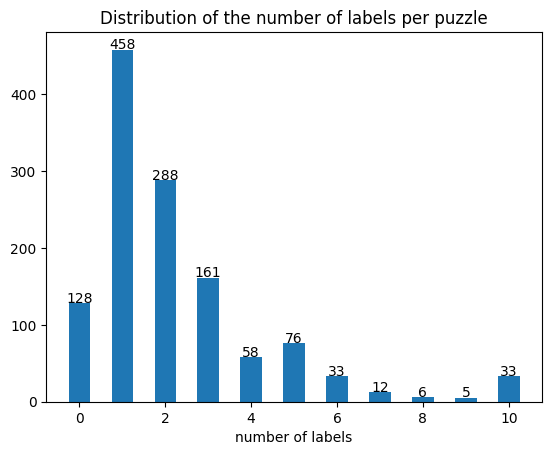

In [120]:
set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in Label_predicted]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 0.95, str(count), ha='center')

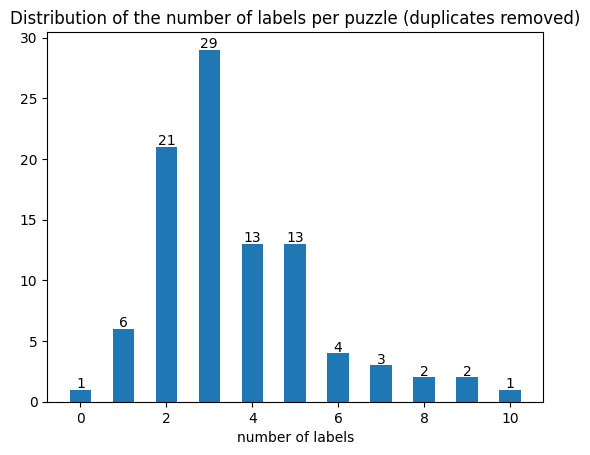

In [121]:
set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in set_of_label_idx]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle (duplicates removed)")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 0.15, str(count), ha='center')